

---

# <center>BaliGuide Recommended Places in Bali Based on Interests</center>

---


Team ID : C23-PC670

Team Member :

*   (ML) M030DSX2507 - Rony Samuel Sinaga
*   (ML) M163DSX3099 - Reyhan Vito Idham Pratama
*   (ML) M330DKX4138 - Carlos Manuel P Situmorang
*   (CC) C151DSY3558 - Azhar Salsabila Naqiyah
*   (CC) C042DSY1946 - Marchelina Naftaly Romauly Tobing
*   (MD) A181DSX2080 - Fransiskus David Yudaputra


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import urllib.request
from PIL import Image as PILImage
from IPython.display import display
import os
import h5py
import pickle
from joblib import dump
import h5py


# Model Makanan Vito

Enter your preference for rating (0-5): 4.6
Enter your preferences regarding location (Ubud/Bali/Kuta/etc):Kuta
Are you looking for halal food or pork? (Halal/Pork): Pork

Top Picks:

Culinary Name: Babi Guling Acharya
Location: Gg. Soka No.48, Kerobokan Kaja, Kec. Kuta Utara, Kabupaten Badung, Bali 80361
Ratings: 5.0
Food Type: Pork


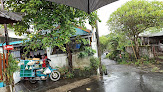


Pretty good choice:

Culinary Name: Babi Tjoy Seminyak Bali
Location: Jl. Dewi Saraswati II No.1, Seminyak, Kec. Kuta, Kabupaten Badung, Bali 80361
Ratings: 4.9
Food Type: Pork


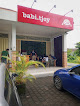


Culinary Name: Babi Guling Anyar Jimbaran
Location: Jl. Danau Batur Raya No.37, Jimbaran, Kec. Kuta Sel., Kabupaten Badung, Bali 80361
Ratings: 4.7
Food Type: Pork


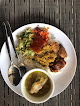


Evaluation Results:
Mean Average Precision (MAP): 1.0


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import urllib.request
from PIL import Image as PILImage
from IPython.display import display
import os
import h5py
import pickle
from joblib import dump

# Membaca dataset_makanan
dataset_makanan = pd.read_csv("https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/Traditional%20food.csv")

# Preprocessing data
dataset_makanan.drop_duplicates(inplace=True)
dataset_makanan.dropna(inplace=True)

# Menormalisasi fitur Rating
scaler_rating_makanan = MinMaxScaler()
dataset_makanan['Normalized Rating_makanan'] = scaler_rating_makanan.fit_transform(dataset_makanan[['Ratings']])


def get_user_preferences_makanan():
    rating_makanan = input("Enter your preference for rating (0-5): ")
    try:
        rating_makanan = float(rating_makanan)
        if not (0 <= rating_makanan <= 5):
            raise ValueError
    except ValueError:
        print("The rating must be within the range of 0 to 5. Please enter a valid number.")
        return None

    location_makanan = input("Enter your preferences regarding location (Ubud/Bali/Kuta/etc):").capitalize()
    if not location_makanan.isalpha():
        print("Sorry, your preferences are not valid. Please enter letters only")
        return None

    halal_makanan = input("Are you looking for halal food or pork? (Halal/Pork): ").capitalize()
    if halal_makanan not in ['Halal', 'Pork']:
        print("Your selection is invalid. Please choose between 'Halal' or 'Pork'.")
        return None


    return [rating_makanan, location_makanan, halal_makanan]


def display_kuliner(kuliner):
    print("\nCulinary Name:", kuliner['Nama'])
    print("Location:", kuliner['Location'])
    print("Ratings:", kuliner['Ratings'])
    print("Food Type:", kuliner['Makanan'])

    # Menampilkan gambar
    foto_makanan = kuliner['Foto']
    if pd.notnull(foto_makanan):
        # Mengambil nama file dari URL gambar
        file_name_makanan = os.path.basename(foto_makanan)
        # Mengunduh gambar dari URL dan menyimpannya ke dalam file lokal
        urllib.request.urlretrieve(foto_makanan, file_name_makanan)
        # Membuka dan menampilkan gambar dari file lokal
        image_makanan = PILImage.open(file_name_makanan)
        display(image_makanan)
        # Menghapus file lokal setelah ditampilkan
        os.remove(file_name_makanan)


def calculate_similarity_makanan(user_preferences_makanan, dataset_makanan):
    if user_preferences_makanan is None or len(user_preferences_makanan) != 3:
        return None, None

    rating_preference_makanan = user_preferences_makanan[0]
    location_preference_makanan = user_preferences_makanan[1]
    halal_preference_makanan = user_preferences_makanan[2]

    kuliner = dataset_makanan[dataset_makanan['Location'].str.contains(location_preference_makanan, case=False)].copy()

    if kuliner.empty:
        print("There are no tourist destinations in", location_preference_makanan, "in the dataset.")
        return None, None

    # Filter berdasarkan jenis makanan (halal atau haram)
    kuliner = kuliner[kuliner['Makanan'].str.contains(halal_preference_makanan, case=False)]

    if kuliner.empty:
        print("There are no tourist destinations that provide food", halal_preference_makanan, "in", location_preference_makanan)
        return None, None

    # Mengambil fitur yang relevan
    relevant_features_makanan = kuliner[['Normalized Rating_makanan']]

    # Normalisasi fitur
    scaler_rating_makanan = MinMaxScaler(feature_range=(0, 1))
    normalized_rating_makanan = scaler_rating_makanan.fit_transform(relevant_features_makanan[['Normalized Rating_makanan']])

    # Menambahkan bobot pada preferensi rating
    weighted_rating_preference_makanan = rating_preference_makanan * 0.6

    if len(normalized_rating_makanan) == 0:
        print("No travel destination matches your preferences.")
        return None, None

    # Menghitung similarity scores dengan bobot preferensi rating
    similarity_scores = cosine_similarity(
        [[weighted_rating_preference_makanan]],
        normalized_rating_makanan
    )

    # Menambahkan kolom Similarity pada DataFrame destinations
    kuliner['Similarity'] = similarity_scores.flatten()

    # Mengurutkan destinasi berdasarkan Similarity
    sorted_kuliner= kuliner.sort_values('Similarity', ascending=False)

    # Pemfilteran destinasi dengan rating di atas preferensi
    filtered_kuliner = sorted_kuliner[sorted_kuliner['Ratings'] > rating_preference_makanan]

    # Jika tidak ada destinasi yang memenuhi preferensi rating
    if filtered_kuliner.empty:
        print("There are no tourist destinations with a rating above", rating_preference_makanan, "in", location_preference_makanan)
        return None, None

    # Memisahkan destinasi teratas dan destinasi cukup oke
    top_kuliner = filtered_kuliner.iloc[0]
    other_kuliner = filtered_kuliner.iloc[1:]

    return top_kuliner, other_kuliner




def evaluate_recommendations_makanan(top_kuliner, other_kuliner):
    if top_kuliner is None:
        return None

    # Menghitung Average Precision
    similarity_scores_makanan = np.concatenate(([1], np.zeros(len(other_kuliner))))
    y_true_makanan = np.zeros(len(similarity_scores_makanan))
    y_true_makanan[0] = 1

    if other_kuliner is not None:
        for i in range(len(other_kuliner)):
            if other_kuliner.iloc[i]['Nama'] == top_kuliner['Nama']:
                y_true_makanan[i + 1] = 1

    average_precision = average_precision_score(y_true_makanan, similarity_scores_makanan)
    return average_precision


# Mengambil preferensi pengguna
user_preferences = get_user_preferences_makanan()

# Menghitung similarity dan merekomendasikan destinasi
top_kuliner, other_kuliner = calculate_similarity_makanan(user_preferences[0:5], dataset_makanan)

# Menampilkan hasil rekomendasi
if top_kuliner is not None:
    print("\nTop Picks:")
    display_kuliner(top_kuliner)

if other_kuliner is not None:
    print("\nPretty good choice:")
    for _, kuliner in other_kuliner.iterrows():
        display_kuliner(kuliner)

# Menampilkan hasil evaluasi
average_precision_makanan = evaluate_recommendations_makanan(top_kuliner, other_kuliner)
if average_precision_makanan is not None:
    print("\nEvaluation Results:")
    print("Mean Average Precision (MAP):", average_precision_makanan)

# Save the model H5
with h5py.File('model_makanan.h5', 'w') as f:
    dset = f.create_group('dataset_makanan')
    for column in dataset_makanan.columns:
        dset.create_dataset(column, data=np.array(dataset_makanan[column]))

# # Simpan model menggunakan pickle
# with open('model_makanan.pkl', 'wb') as f:
#     pickle.dump(dataset_makanan, f)

# # Simpan model menggunakan joblib
# dump(dataset_makanan, 'model_makanan.joblib')


# Model Model Oleh Oleh Vito

Enter your preference regarding the rating (0-5): 4.8
Enter your preferences regarding location (Ubud/Bali/Kuta/etc):Kuta
Enter your preferences regarding opening hours (format: HH:MM): 06:00
Enter your preferences regarding closing hours (format: HH:MM): 23:00

Top Picks:

Store Name: Prema Rasa Oleh Oleh Khas Bali
Location: Jl. Raya Kuta No.85, Tuban,Kabupaten Badung
Ratings: 5.0
Opening Hours: 08:00
Closing Hours: 23:00


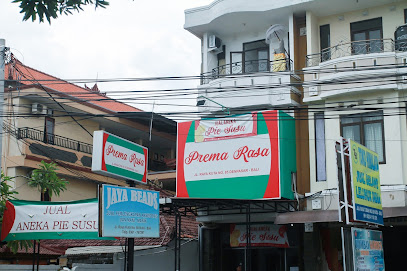


Pretty good choice::

Store Name: Surya Bali Oleh-Oleh Khas Bali
Location: Jl. Raya Kuta No.61, Kuta,Kabupaten Badung
Ratings: 5.0
Opening Hours: 08:00
Closing Hours: 23:00


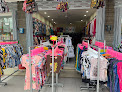


Store Name: Snack Meyuk! Oleh-Oleh Khas Bali
Location: Jl. Patih Jelantik No.55, Legian, Kec. Kuta, Kabupaten Badung
Ratings: 5.0
Opening Hours: 09:00
Closing Hours: 21:18


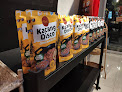


Evaluation Results:
Mean Average Precision (MAP): 1.0


In [2]:
# Membaca dataset
dataset_oleh = pd.read_csv("https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/Souvenir%20Place.csv")

# Preprocessing data
dataset_oleh.drop_duplicates(inplace=True)
dataset_oleh.dropna(inplace=True)

# Menormalisasi fitur Rating
scaler_rating_oleh = MinMaxScaler()
dataset_oleh['Normalized Rating_oleh'] = scaler_rating_oleh.fit_transform(dataset_oleh[['Rating']])
# Menormalisasi fitur Open dan Close
scaler_open_oleh = MinMaxScaler()
dataset_oleh['Normalized Open_oleh'] = scaler_open_oleh.fit_transform(dataset_oleh[['Open']])
scaler_close_oleh = MinMaxScaler()
dataset_oleh['Normalized Close_oleh'] = scaler_close_oleh.fit_transform(dataset_oleh[['Close']])

# Mengubah tipe data kolom 'Foto' menjadi string
dataset_makanan['Foto'] = dataset_makanan['Foto'].astype(str)


def get_user_preferences_oleh():
    rating_oleh = input("Enter your preference regarding the rating (0-5): ")
    try:
        rating_oleh = float(rating_oleh)
        if not (0 <= rating_oleh <= 5):
            raise ValueError
    except ValueError:
        print("The rating must be within the range of 0 to 5. Please enter a valid number.")
        return None

    location_oleh= input("Enter your preferences regarding location (Ubud/Bali/Kuta/etc):").capitalize()
    if not location_oleh.isalpha():
        print("Sorry, your preferences are not valid. Please enter letters only.")
        return None

    open_time_oleh = input("Enter your preferences regarding opening hours (format: HH:MM): ")
    try:
        open_time_oleh= open_time_oleh.split(':')
        open_time_oleh = int(open_time_oleh[0]) + int(open_time_oleh[1])/60
        if not (0 <= open_time_oleh <= 24):
            raise ValueError
    except ValueError:
        print("The opening hours must be within the range of 0 to 24. Please enter a valid number.")
        return None

    close_time_oleh= input("Enter your preferences regarding closing hours (format: HH:MM): ")
    try:
        close_time_oleh = close_time_oleh.split(':')
        close_time_oleh = int(close_time_oleh[0]) + int(close_time_oleh[1])/60
        if not (0 <= close_time_oleh <= 24):
            raise ValueError
    except ValueError:
        print("The closing hours must be within the range of 0 to 24. Please enter a valid number.")
        return None

    return [rating_oleh, location_oleh, open_time_oleh, close_time_oleh]


import os

def display_oleh(oleh):
    print("\nStore Name:", oleh['Nama'])
    print("Location:", oleh['Location'])
    print("Ratings:", oleh['Rating'])
    print("Opening Hours:", "{:0>2d}:{:0>2d}".format(int(oleh['Open']), int((oleh['Open'] - int(oleh['Open'])) * 60)))
    print("Closing Hours:", "{:0>2d}:{:0>2d}".format(int(oleh['Close']), int((oleh['Close'] - int(oleh['Close'])) * 60)))

    # Menampilkan gambar
    foto_oleh = oleh['Foto']
    if pd.notnull(foto_oleh):
        # Mengambil nama file dari URL gambar
        file_name_oleh = os.path.basename(foto_oleh)
        # Mengunduh gambar dari URL dan menyimpannya ke dalam file lokal
        urllib.request.urlretrieve(foto_oleh, file_name_oleh)
        # Membuka dan menampilkan gambar dari file lokal
        image_oleh = PILImage.open(file_name_oleh)
        display(image_oleh)
        # Menghapus file lokal setelah ditampilkan
        os.remove(file_name_oleh)

def calculate_similarity_oleh(user_preferences_oleh, dataset_oleh):
    if user_preferences_oleh is None or len(user_preferences_oleh) != 4:
        return None, None

    rating_preference_oleh = user_preferences_oleh[0]
    location_preference_oleh= user_preferences_oleh[1]
    open_time_preference_oleh = user_preferences_oleh[2]
    close_time_preference_oleh = user_preferences_oleh[3]

    oleh = dataset_oleh[dataset_oleh['Location'].str.contains(location_preference_oleh, case=False)].copy()

    if oleh.empty:
        print("There are no tourist destinations in", location_preference_oleh, "in the dataset.")
        return None, None

    # Mengambil fitur yang relevan
    relevant_features_oleh = oleh[['Normalized Rating_oleh', 'Normalized Open_oleh', 'Normalized Close_oleh']]

    # Normalisasi fitur
    scaler_rating_oleh = MinMaxScaler(feature_range=(0, 1))
    normalized_rating_oleh = scaler_rating_oleh.fit_transform(relevant_features_oleh[['Normalized Rating_oleh']])

    scaler_open_oleh = MinMaxScaler(feature_range=(0, 1))
    normalized_open_oleh = scaler_open_oleh.fit_transform(relevant_features_oleh[['Normalized Open_oleh']])

    scaler_close_oleh = MinMaxScaler(feature_range=(0, 1))
    normalized_close_oleh= scaler_close_oleh.fit_transform(relevant_features_oleh[['Normalized Close_oleh']])

    # Menggabungkan fitur yang telah dinormalisasi menjadi sebuah array tunggal
    normalized_features_oleh = np.concatenate((normalized_rating_oleh, normalized_open_oleh, normalized_close_oleh), axis=1)

    # Menambahkan bobot pada preferensi rating
    weighted_rating_preference_oleh = rating_preference_oleh * 0.6

    if len(normalized_rating_oleh) == 0:
        print("There is no travel destination that suits your preferences.")
        return None, None

    # Menghitung similarity scores dengan bobot preferensi rating
    similarity_scores_oleh = cosine_similarity(
        [[weighted_rating_preference_oleh, open_time_preference_oleh, close_time_preference_oleh]],
        normalized_features_oleh
    )

    # Menambahkan kolom Similarity pada DataFrame destinations
    oleh['Similarity'] = similarity_scores_oleh.flatten()

    # Mengurutkan destinasi berdasarkan Similarity
    sorted_oleh = oleh.sort_values('Similarity', ascending=False)

    # Pemfilteran destinasi dengan rating di atas preferensi
    filtered_oleh= sorted_oleh[sorted_oleh['Rating'] > rating_preference_oleh]

    # Jika tidak ada destinasi yang memenuhi preferensi rating
    if filtered_oleh.empty:
        print("There are no tourist destinations with a rating above", rating_preference_oleh, "in", location_preference_oleh)
        return None, None

    # Memisahkan destinasi teratas dan destinasi cukup oke
    top_oleh = filtered_oleh.iloc[0]
    other_oleh = filtered_oleh.iloc[1:]

    return top_oleh, other_oleh


def evaluate_recommendations(top_oleh, other_oleh):
    if top_oleh is None:
        return None

    # Menghitung Average Precision
    similarity_scores_oleh = np.concatenate(([1], np.zeros(len(other_oleh))))
    y_true_oleh = np.zeros(len(similarity_scores_oleh))
    y_true_oleh[0] = 1

    if other_oleh is not None:
        for i in range(len(other_oleh)):
            if other_oleh.iloc[i]['Nama'] == top_oleh['Nama']:
                y_true_oleh[i + 1] = 1

    average_precision_oleh = average_precision_score(y_true_oleh, similarity_scores_oleh)
    return average_precision_oleh


# Mengambil preferensi pengguna
user_preferences_oleh = get_user_preferences_oleh()

# Menghitung similarity dan merekomendasikan destinasi
top_oleh, other_oleh = calculate_similarity_oleh(user_preferences_oleh, dataset_oleh)

# Menampilkan hasil rekomendasi
if top_oleh is not None:
    print("\nTop Picks:")
    display_oleh(top_oleh)

if other_oleh is not None:
    print("\nPretty good choice::")
    for _, oleh in other_oleh.iterrows():
        display_oleh(oleh)

# Menampilkan hasil evaluasi
average_precision_oleh = evaluate_recommendations(top_oleh, other_oleh)
if average_precision_oleh is not None:
    print("\nEvaluation Results:")
    print("Mean Average Precision (MAP):", average_precision_oleh)

# Save the model
with h5py.File('model_oleholeh.h5', 'w') as f:
    dset = f.create_group('dataset_makanan')
    for column in dataset_makanan.columns:
        dset.create_dataset(column, data=np.array(dataset_makanan[column]))

# # Simpan model menggunakan pickle
# with open('model_oleholeh.pkl', 'wb') as f:
#     pickle.dump(dataset_makanan, f)

# # Simpan model menggunakan joblib
# dump(dataset_makanan, 'model_oleholeh.joblib')


# Model destinasi turis



In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import urllib.request
from PIL import Image
from IPython.display import display
import requests
from PIL import Image
from io import BytesIO
import requests
import json



# Membaca dataset
dataset_destinasi_turis = pd.read_csv("https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/dataset_destinasi_turis.csv")





# Preprocessing data
dataset_destinasi_turis.drop_duplicates(inplace=True)
dataset_destinasi_turis.dropna(inplace=True)


# Menormalisasi fitur Entrance Fee dan Rating
scaler_entrance_fee_destinasi_turis = MinMaxScaler(feature_range=(0, 1))
normalized_entrance_fee = scaler_entrance_fee_destinasi_turis.fit_transform(dataset_destinasi_turis[['Entrance Fee']])
normalized_entrance_fee = pd.DataFrame(normalized_entrance_fee, columns=['Normalized Entrance Fee'])

scaler_rating_destinasi_turis = MinMaxScaler(feature_range=(0, 1))
normalized_rating = scaler_rating_destinasi_turis.fit_transform(dataset_destinasi_turis[['Rating']])
normalized_rating = pd.DataFrame(normalized_rating, columns=['Normalized Rating'])

# Menggabungkan hasil normalisasi dengan dataset
dataset_destinasi_turis = pd.concat([dataset_destinasi_turis, normalized_entrance_fee, normalized_rating], axis=1)

def get_user_preferences_destinasi_turis():
    entrance_fee_destinasi_turis_input = input("Masukkan preferensi terkait dengan Budget Anda (0/1000/100000): ")

    if entrance_fee_destinasi_turis_input.lower() == "gratis":
        entrance_fee_destinasi_turis_input = 0
    elif not entrance_fee_destinasi_turis_input.replace(".", "", 1).isdigit() or float(entrance_fee_destinasi_turis_input) < 0 or float(entrance_fee_destinasi_turis_input) > 100000000:
        print("Mohon maaf, preferensi Anda tidak valid. Silakan masukkan angka 0, 1000, atau 100000.")
        return None

    rating_destinasi_turis_input = input("Masukkan preferensi Anda terkait rating (0-5): ")
    if not rating_destinasi_turis_input.replace(".", "", 1).isdigit() or float(rating_destinasi_turis_input) < 0 or float(rating_destinasi_turis_input) > 5:
        print("Mohon maaf, preferensi Anda tidak valid. Silakan masukkan angka antara 0 hingga 5.")
        return None

    rating_destinasi_turis_input = float(rating_destinasi_turis_input)

    location_destinasi_turis_input  = input("Masukkan preferensi Anda terkait lokasi (Ubud/Bali/Kuta/Dll): ").capitalize()
    if not location_destinasi_turis_input.isalpha():
        print("Mohon maaf, preferensi Anda tidak valid. Silakan masukkan huruf-huruf saja.")
        return None

    return [entrance_fee_destinasi_turis_input, rating_destinasi_turis_input, location_destinasi_turis_input]

def display_destination(destination):
    print("\nNama Destinasi:", destination['Nama'])
    print("Lokasi:", destination['Location'])
    print("Harga Tiket Masuk Untuk Lokasi ini:", destination['Entrance Fee'])
    print("Rating:", destination['Rating'])

    # foto_destination = destination['Foto']
    # if pd.notnull(foto_destination):
    #     # Mengambil nama file dari URL gambar
    #     file_name_destinasi = os.path.basename(foto_destination)
    #     # Mengunduh gambar dari URL dan menyimpannya ke dalam file lokal
    #     urllib.request.urlretrieve(foto_destination, file_name_destinasi)
    #     # Membuka dan menampilkan gambar dari file lokal
    #     image_destinasi = PILImage.open(file_name_destinasi)
    #     display(image_destinasi)
    #     # Menghapus file lokal setelah ditampilkan
    #     os.remove(image_destinasi)


# def display_image(destination, path_gambar_destinasi_turis):
#     if isinstance(destination, pd.DataFrame):  # Memeriksa apakah `destination` merupakan DataFrame
#         for index, row in destination.iterrows():
#             urutan_dataset = index + 1
#             nama_destinasi = row['Nama']  # Mengambil nama destinasi

#             nama_file_gambar = str(urutan_dataset) + ".jpg"  # Membuat nama file gambar
#             path_gambar = os.path.join(path_gambar_destinasi_turis, nama_file_gambar)  # Mengonstruksi path gambar

#             if os.path.exists(path_gambar):
#                 img = Image.open(path_gambar)
#                 img = img.resize((300, 300))
#                 display(img)
#             else:
#                 print("Gambar tidak ditemukan.")
#     else:
#         urutan_dataset = destination.name + 1  # Mengambil urutan dataset untuk nama file
#         nama_destinasi = destination['Nama']  # Mengambil nama destinasi

#         nama_file_gambar = str(urutan_dataset) + ".jpg"  # Membuat nama file gambar
#         path_gambar = os.path.join(path_gambar_destinasi_turis, nama_file_gambar)  # Mengonstruksi path gambar

#         if os.path.exists(path_gambar):
#             img = Image.open(path_gambar)
#             img = img.resize((300, 300))
#             display(img)
#         else:
#             print("Gambar tidak ditemukan.")






def calculate_similarity_destination(user_preferences, dataset):
    if user_preferences is None:
        return None, None

    entrance_fee_preference = user_preferences[0]
    rating_preference = user_preferences[1]
    location_preference = user_preferences[2]

    destinations = dataset.copy()

    if entrance_fee_preference != 0:
        destinations = destinations[destinations['Entrance Fee'] != "Gratis"]
    destinations['Entrance Fee'] = destinations['Entrance Fee'].astype(float)

    destinations = destinations[destinations['Location'].str.contains(location_preference, case=False)]

    if destinations.empty:
        print("Tidak ada destinasi wisata di", location_preference, "dalam dataset.")
        return None, None

    # Mengambil fitur yang relevan
    relevant_features = destinations[['Normalized Entrance Fee', 'Normalized Rating']]

    # Normalisasi preferensi pengguna
    normalized_entrance_fee_preference = scaler_entrance_fee_destinasi_turis.transform([[entrance_fee_preference]])[0][0]
    normalized_rating_preference = scaler_entrance_fee_destinasi_turis.transform([[rating_preference]])[0][0]

    # Menambahkan bobot pada preferensi harga tiket masuk dan rating
    weighted_entrance_fee_preference = normalized_entrance_fee_preference * 0.7  # Bobot harga tiket masuk lebih tinggi
    weighted_rating_preference = normalized_rating_preference * 0.3  # Bobot rating lebih rendah

    if len(destinations) == 0:
        print("Tidak ada destinasi wisata yang sesuai dengan preferensi Anda.")
        return None, None

    # Menghitung similarity scores menggunakan cosine similarity dengan bobot
    similarity_scores = (weighted_entrance_fee_preference * destinations['Normalized Entrance Fee']) + (weighted_rating_preference * destinations['Normalized Rating'])
    # Menambahkan kolom Similarity pada DataFrame destinations
    destinations['Similarity'] = similarity_scores

    # Mengurutkan destinasi berdasarkan Similarity dan Entrance Fee
    sorted_destinations = destinations.sort_values(['Similarity', 'Entrance Fee'], ascending=[False, True])

    # Memisahkan destinasi teratas dan destinasi cukup oke
    top_destination = sorted_destinations.iloc[0]
    other_destinations = sorted_destinations.iloc[1:]


    return top_destination, other_destinations

def evaluate_recommendations_destination(top_destination, other_destinations):
    if top_destination is None:
        return None

    # Menghitung Average Precision
    similarity_scores = np.concatenate(([1], np.zeros(len(other_destinations))))
    y_true = np.zeros(len(similarity_scores))
    y_true[0] = 1

    if other_destinations is not None:
        for i in range(len(other_destinations)):
            if other_destinations.iloc[i]['Nama'] == top_destination['Nama']:
                y_true[i+1] = 1

    average_precision = average_precision_score(y_true, similarity_scores)
    return average_precision

# Mengambil preferensi pengguna
user_preferences_destinasi_turis = get_user_preferences_destinasi_turis()

# Menghitung similarity dan merekomendasikan destinasi
top_destination, other_destinations = calculate_similarity_destination(user_preferences_destinasi_turis, dataset_destinasi_turis)

# def display_image(destination):
#     image_path = path_gambar_destinasi_turis + '/' + destination['Image']
#     display(Image.open(image_path))

# Menampilkan hasil rekomendasi
if top_destination is not None:
    print("\nPilihan Teratas:")
    display_destination(top_destination)
    display_image(top_destination, path_gambar_destinasi_turis)

if other_destinations is not None:
    other_destinations = other_destinations.drop_duplicates(subset='Nama')
    print("\nPilihan Cukup Oke:")
    for index, destination in other_destinations.head(9).iterrows():
        display_destination(destination)
        # display_image(destination, path_gambar_destinasi_turis)
else:
    print("Tidak ada pilihan cukup oke yang dapat ditampilkan.")


# Fungsi untuk menampilkan gambar



# Menampilkan hasil evaluasi
average_precision = evaluate_recommendations_destination(top_destination, other_destinations)
if average_precision is not None:
    print("\nHasil Evaluasi:")


Masukkan preferensi Anda terkait rating (0-5): 0


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score
import urllib.request

url = "https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/dataset_destinasi_turis.csv"
filename = "dataset_destinasi_turis.csv"
urllib.request.urlretrieve(url, filename)

dataset_destinasi_turis = tf.data.experimental.CsvDataset(filename, record_defaults=[tf.string, tf.float32, tf.float32, tf.string, tf.string])


# Preprocessing data
# Preprocessing data
dataset_destinasi_turis = dataset_destinasi_turis.map(lambda *x: (x[0], tf.strings.to_number(x[1], out_type=tf.float32), x[2], x[3], x[4], tf.strings.to_number(x[5], out_type=tf.float32).numpy()))








scaler = MinMaxScaler(feature_range=(0, 1))
entrance_fee = [x.numpy() for x in dataset_destinasi_turis.map(lambda *x: x[1])]
rating = [x.numpy() for x in dataset_destinasi_turis.map(lambda *x: x[2])]
normalized_entrance_fee = scaler.fit_transform(entrance_fee)
normalized_rating = scaler.fit_transform(rating)
dataset_destinasi_turis = tf.data.Dataset.from_tensor_slices((dataset_destinasi_turis[0], normalized_entrance_fee, normalized_rating, dataset_destinasi_turis[3], dataset_destinasi_turis[4]))



# Mengonversi dataset menjadi Pandas DataFrame untuk evaluasi
dataset_destinasi_turis_df = pd.DataFrame(list(dataset_destinasi_turis.as_numpy_iterator()), columns=["Nama", "Normalized Entrance Fee", "Normalized Rating", "Location", "Foto"])

# Menyiapkan data pelatihan dan evaluasi
train_dataset = dataset_destinasi_turis.map(lambda x1, x2, x3, x4, x5: (x2, x3))
train_dataset = train_dataset.shuffle(1000).batch(32)

# Membangun model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Mengompilasi model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

# Melatih model
model.fit(train_dataset, epochs=10, validation_split=0.2)  # Menambahkan validation_split dengan nilai 0.2

# Evaluasi model pada set validasi
val_loss, val_mae = model.evaluate(train_dataset, verbose=0)

print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)

# Fungsi untuk menghitung similarity destination menggunakan model yang telah dilatih
def calculate_similarity_destination(user_preferences, dataset):
    if user_preferences is None:
        return None, None

    entrance_fee_preference = user_preferences[0]
    rating_preference = user_preferences[1]
    location_preference = user_preferences[2]

    destinations = dataset.copy()

    # Preprocessing data
    destinations = destinations[destinations['Normalized Entrance Fee'] != "Gratis"]
    destinations['Normalized Entrance Fee'] = destinations['Normalized Entrance Fee'].astype(float)
    destinations = destinations[destinations['Location'].str.contains(location_preference, case=False)]

    if destinations.empty:
        print("Tidak ada destinasi wisata di", location_preference, "dalam dataset.")
        return None, None

    # Mengambil fitur yang relevan
    relevant_features = destinations[['Normalized Entrance Fee', 'Normalized Rating']]

    # Normalisasi preferensi pengguna
    scaler = MinMaxScaler(feature_range=(0, 1))
    entrance_fee_preference_normalized = scaler.fit_transform([[entrance_fee_preference]])[0][0]
    rating_preference_normalized = scaler.fit_transform([[rating_preference]])[0][0]

    # Menambahkan bobot pada preferensi harga tiket masuk dan rating
    relevant_features['Entrance Fee Weight'] = relevant_features['Normalized Entrance Fee'].apply(
        lambda x: entrance_fee_preference_normalized - x if entrance_fee_preference_normalized > x else 0)
    relevant_features['Rating Weight'] = relevant_features['Normalized Rating'].apply(
        lambda x: rating_preference_normalized - x if rating_preference_normalized > x else 0)

    # Menghitung skor similarity destination
    relevant_features['Similarity Score'] = relevant_features.apply(
        lambda row: tf.sigmoid(
            tf.constant([[row['Entrance Fee Weight'], row['Rating Weight']]]).numpy().dot(model.get_weights()[0]) + model.get_weights()[1]),
        axis=1)

    # Menggabungkan hasil similarity dengan dataset destinasi
    destinations['Similarity Score'] = relevant_features['Similarity Score']
    destinations = destinations.sort_values(by='Similarity Score', ascending=False)

    return destinations[['Nama', 'Location', 'Similarity Score']]

# Contoh penggunaan fungsi calculate_similarity_destination
user_preferences = [0.5, 0.8, "Ubud"]
result = calculate_similarity_destination(user_preferences, dataset_destinasi_turis_df)
print(result)


TypeError: ignored

# Model Rekomendasi Hotel


In [ ]:
# Membaca dataset
dataset_hotel = pd.read_csv("https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/Hotel%20Destination.csv")
dataset_hotel.head()


,Name,Budget,Lokasi,Rating,Picture
0,Atanaya Kuta Bali,1125590.0,"Jl. Sunset Road No.88A, Kuta, Kec. Kuta, Kabup...",4.30,https://drive.google.com/file/d/1x2XArj5Nh6x8m...
1,ASTON Denpasar Hotel & Convention Center,818550.0,"Jl. Gatot Subroto Barat No.283, Pemecutan Kaja...",4.12,https://drive.google.com/file/d/1b74wZAcZ3mudC...
2,Hilton Bali Resort,3569500.0,"Jl. Raya Nusa Dua Selatan, Benoa, Kec. Kuta Se...",4.40,https://drive.google.com/file/d/1Y8hksph6kMKdF...
3,Potato Head Suites & Studios,4484000.0,"Jl. Petitenget No. 51B, Seminyak. Kuta Utara, ...",4.60,https://drive.google.com/file/d/1tjY9oXgX5MSaZ...
4,Asvara Villa Ubud by Ini Vie Hospitality,2022779.0,"Jalan Bangkiang Sidem No.8x Ubud, Ubud, Payang...",4.40,https://drive.google.com/file/d/11x-fWyez3fvio...


In [ ]:
# Preprocessing data
dataset_hotel.drop_duplicates(inplace=True)
dataset_hotel.dropna(inplace=True)

In [ ]:
# Menormalisasi fitur Entrance Fee dan Rating
scaler_budget_hotel = MinMaxScaler()
dataset_hotel['Normalized Budget'] = scaler_budget_hotel.fit_transform(dataset_hotel[['Budget']])

scaler_rating_hotel = MinMaxScaler()
dataset_hotel['Normalized Rating'] = scaler_rating_hotel.fit_transform(dataset_hotel[['Rating']])

def get_user_preferences_hotel():
    budget_hotel = input("Enter preferences related to your Budget: ")

    rating_hotel = input("Enter your preferences regarding ratings (0-5): ")
    try:
        rating_hotel = float(rating_hotel)
        if not (0 <= rating_hotel <= 5):
            raise ValueError
    except ValueError:
        print("Rating must be in the range of 0 to 5. Please enter a valid number.")
        return None

    location_hotel = input("Enter your preference regarding location (Ubud/Bali/Kuta/Etc): ").capitalize()
    if not location_hotel.isalpha():
        print("Sorry, your preference is not valid. Please enter only letters.")
        return None

    return [budget_hotel, rating_hotel, location_hotel]

def display_hotel(hotel):
    print("\nHotel Name:", hotel['Name'])
    print("Location:", hotel['Lokasi'])
    print("Budget:", hotel['Budget'])
    print("Rating:", hotel['Rating'])
    print("Picture:", hotel['Picture'])



def calculate_similarity(user_preferences_hotel, dataset_hotel):
    if user_preferences_hotel is None:
        return None, None

    budget_hotel_preference = user_preferences_hotel[0]
    rating_hotel_preference = user_preferences_hotel[1]
    location_hotel_preference = user_preferences_hotel[2]

    hotels = dataset_hotel[dataset_hotel['Lokasi'].str.contains(location_hotel_preference, case=False)].copy()

    if hotels.empty:
        print("There are no hotels in", location_hotel_preference, "dataset_hotels.")
        return None, None

    # Mengambil fitur yang relevan
    relevant_features_hotel = hotels[['Budget', 'Rating']]

    # Normalisasi fitur
    scaler_budget_hotel = MinMaxScaler(feature_range=(0, 1))
    normalized_budget = scaler_budget_hotel.fit_transform(relevant_features_hotel[['Budget']])
    scaler_rating_hotel = MinMaxScaler(feature_range=(0, 1))
    normalized_rating = scaler_rating_hotel.fit_transform(relevant_features_hotel[['Rating']])

    # Normalisasi preferensi pengguna
    normalized_budget_hotel_preference = scaler_budget_hotel.transform([[budget_hotel_preference]])[0][0]
    normalized_rating_hotel_preference = scaler_rating_hotel.transform([[rating_hotel_preference]])[0][0]

    # Menambahkan bobot pada preferensi harga tiket masuk dan rating
    weighted_budget_hotel_preference = normalized_budget_hotel_preference * 0.6
    weighted_rating_hotel_preference = normalized_rating_hotel_preference * 0.6

    if len(normalized_budget) == 0 or len(normalized_rating) == 0:
        print("There are no hotels that match your preference.")
        return None, None

    # Menghitung similarity scores menggunakan cosine similarity dengan bobot
    similarity_scores = cosine_similarity(
        [[weighted_budget_hotel_preference, weighted_rating_hotel_preference]],
        np.concatenate((normalized_budget, normalized_rating), axis=1)
    )

    # Menambahkan kolom Similarity pada DataFrame hotels
    hotels['Similarity'] = similarity_scores.flatten()

    # Mengurutkan destinasi berdasarkan Similarity
    sorted_hotels = hotels.sort_values('Similarity', ascending=False)

    # Memisahkan destinasi teratas dan destinasi cukup oke
    top_hotel = sorted_hotels.iloc[0]
    other_hotels = sorted_hotels.iloc[1:]

    return top_hotel, other_hotels

def evaluate_recommendations(top_hotel, other_hotels):
    if top_hotel is None:
        return None

    # Menghitung Average Precision
    similarity_scores = np.concatenate(([1], np.zeros(len(other_hotels))))
    y_true = np.zeros(len(similarity_scores))
    y_true[0] = 1

    if other_hotels is not None:
        for i in range(len(other_hotels)):
            if other_hotels.iloc[i]['Name'] == top_hotel['Name']:
                y_true[i+1] = 1

    average_precision = average_precision_score(y_true, similarity_scores)
    return average_precision

# Mengambil preferensi pengguna
user_preferences_hotel = get_user_preferences_hotel()

# Menghitung similarity dan merekomendasikan destinasi
top_hotel, other_hotels = calculate_similarity(user_preferences_hotel, dataset_hotel)

# Menampilkan hasil rekomendasi
if top_hotel is not None:
    print("\nTop Picks:")
    display_hotel(top_hotel)

if other_hotels is not None:
    print("\nPretty good choice:")
    for _, hotel in other_hotels.head(9).iterrows():
        display_hotel(hotel)

# Menampilkan hasil evaluasi
average_precision = evaluate_recommendations(top_hotel, other_hotels)
if average_precision is not None:
    print("\nEvaluation result:")
    print("Mean Average Precision (MAP):", average_precision)


Enter preferences related to your Budget: 1000000
Enter your preferences regarding ratings (0-5): 4.6
Enter your preference regarding location (Ubud/Bali/Kuta/Etc): Ubud

Top Picks:

Hotel Name: Sujiwa Ubud Retreat Villa
Location: Jl. Subak Gunung Sari, Sumampan, Kemenuh, 80571 Ubud, Bali, 80571 Ubud, Indonesia, Ubud, Kemenuh, Bali, Indonesia, 80571
Budget: 625000.0
Rating: 4.3
Picture: https://drive.google.com/file/d/1ausP934SrBslvaAz8n49shmv4KfjqrZa/view?usp=sharing

Pretty good choice:

Hotel Name: Gana Hotel & Restaurant
Location: Jalan Pengosekan, Ubud, Monkey Forest, Bali, Indonesia, 80571
Budget: 573750.0
Rating: 4.45
Picture: https://drive.google.com/file/d/1metNB1qqLBszbNNC47JwmY8uNvg909uX/view?usp=sharing

Hotel Name: Kubu Bali Baik Villa & Resort 
Location: Br. Umah Anyar Pejeng Kawan Tampaksiring , Ubud, Tampaksiring, Bali, Indonesia, 80552
Budget: 561600.0
Rating: 4.4
Picture: https://drive.google.com/file/d/1KnyFFbcHcpGC4GfkDzpjGDNH4UE7eZxm/view?usp=sharing

Hotel Name: U

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Save the model
import h5py

with h5py.File('model_Hotel.h5', 'w') as f:
    dset = f.create_group('dataset_hotel')
    for column in dataset_hotel.columns:
        if column in dset:
            del dset[column]  # Delete the existing dataset with the same name

        dset.create_dataset(column, data=np.array(dataset_cafe[column]))

# Model Rekomendasi Cafe


In [ ]:
# Membaca dataset
dataset_cafe = pd.read_csv("https://raw.githubusercontent.com/Capstone-Bangkit-C23-PC670/BaliGuideML/main/Dataset/Cafe%20Destination.csv")
dataset_cafe.head()

,Name,ratings,location,description,open_hours,Opened,Closed,phone_number,Picture
0,Coffee Cartel,4.5,"Jl. Lb. Sari No.8, Kerobokan Kelod, Kec. Kuta ...",Kafe kosmopolitan dengan suasana santai menyaj...,07.30–18.00,07.30,18.00,0812-3707-4458,https://lh5.googleusercontent.com/p/AF1QipN7pm...
1,Watercress Cafe,4.6,"Jl. Batu Belig No.21 A, Kerobokan Kelod, Kec. ...",Restoran trendi yang disukai wisatawan asing d...,07.00–22.00,07.00,22.00,0812-3817-2422,https://lh5.googleusercontent.com/p/AF1QipO9O0...
2,Cinta cafe,4.5,"Jl. Pantai Berawa No.69, Tibubeneng, Kec. Kuta...",Relaxed open-air cafe featuring a menu of comf...,08.00–23.00,08.00,23.00,0851-0280-8031,https://lh5.googleusercontent.com/p/AF1QipMW3e...
3,Shelter Cafe Seminyak,4.4,"Jl. Drupadi 1 No.2b, Seminyak, Kec. Kuta, Kabu...",· Makan di tempat · Bawa pulang · Pesan antar,08.00–16.00,08.00,16.00,0821-4706-4407,https://lh5.googleusercontent.com/p/AF1QipPKhB...
4,Unicorn Cafe Bali by Brie,4.3,"Canggu, Lapangan sempol, Jl. Sempol, Pererenan...",· Makan di tempat,08.00–17.00,08.00,17.00,0813-3979-4619,https://lh5.googleusercontent.com/p/AF1QipObLj...


In [ ]:
# Preprocessing data
dataset_cafe.drop_duplicates(inplace=True)
dataset_cafe.dropna(inplace=True)

In [ ]:
# Menormalisasi fitur Entrance Fee dan Rating

scaler_rating_cafe = MinMaxScaler(feature_range=(0, 1))
normalized_rating_cafe = scaler_rating_cafe.fit_transform(dataset_cafe[['ratings']])
normalized_rating_cafe = pd.DataFrame(normalized_rating_cafe, columns=['Normalized Rating'])

# Menggabungkan hasil normalisasi dengan dataset
dataset_cafe = pd.concat([dataset_cafe, normalized_rating_cafe], axis=1)

def get_user_preferences_cafe():
    rating_cafe = input("Enter your preferences regarding ratings (0-5): ")
    try:
        rating_cafe = float(rating_cafe)
        if not (0 <= rating_cafe <= 5):
            raise ValueError
    except ValueError:
        print("Rating must be in the range of 0 to 5. Please enter a valid number.")
        return None

    location_cafe = input("Enter your preference regarding location (Ubud/Bali/Kuta/Etc): ").capitalize()
    if not location_cafe.isalpha():
        print("Sorry, your preference is not valid. Please enter only letters.")
        return None

    description_cafe = input("Enter your preference regarding facility (Wi-Fi/Pesan antar/Bawa pulang/Etc): ").capitalize()
    if not description_cafe.isalpha():
        print("Sorry, your preference is not valid. Please enter only letters.")
        return None

    return [rating_cafe, location_cafe, description_cafe]

def display_cafe(cafe):
    print("\ncafe Name:", cafe['Name'])
    print("Rating:", cafe['ratings'])
    print("Facility:", cafe['description'])
    print("Location:", cafe['location'])

    # Handle the time conversion

    opened_time = cafe['Opened']
    closed_time = cafe['Closed']

    if opened_time == 'Buka 24 jam' and closed_time == 'Buka 24 jam':
        print("Open hours: Buka 24 jam")
    else:
        opened_hours = int(float(opened_time))  # Convert to float first, then to int
        opened_minutes = int((float(opened_time) - opened_hours) * 60)
        closed_hours = int(float(closed_time))  # Convert to float first, then to int
        closed_minutes = int((float(closed_time) - closed_hours) * 60)

        print("Opened:", "{:0>2d}.{:0>2d}".format(opened_hours, opened_minutes))
        print("Closed:", "{:0>2d}.{:0>2d}".format(closed_hours, closed_minutes))
    print("Phone Number:", cafe['phone_number'])

    print("Picture:", cafe['Picture'])


def calculate_similarity(user_preferences_cafe, dataset):
    if user_preferences_cafe is None:
        return None, None

    rating_cafe_preference = user_preferences_cafe[0]
    location_cafe_preference = user_preferences_cafe[1]
    description_cafe_preference = user_preferences_cafe[2]

    cafes = dataset[dataset['location'].str.contains(location_cafe_preference, case=False)].copy()

    if cafes.empty:
        print("There are no cafes in", location_cafe_preference, "datasets.")
        return None, None

    # Mengambil fitur yang relevan
    relevant_features_cafe = cafes[['ratings']]

    # Normalisasi fitur
    scaler_rating = MinMaxScaler(feature_range=(0, 1))
    normalized_rating_cafe = scaler_rating.fit_transform(relevant_features_cafe[['ratings']])

    # Normalisasi preferensi pengguna
    normalized_rating_cafe_preference = scaler_rating.transform([[rating_cafe_preference]])[0][0]

    # Menambahkan bobot pada preferensi harga tiket masuk dan rating
    weighted_rating_cafe_preference = np.array([[normalized_rating_cafe_preference]]) * 0.6

    # Menghitung similarity scores menggunakan cosine similarity dengan bobot
    similarity_scores = cosine_similarity(weighted_rating_cafe_preference.reshape(1, -1), normalized_rating_cafe)

    # Menambahkan kolom Similarity pada DataFrame cafes
    cafes['Similarity'] = similarity_scores.flatten()

    # Mengurutkan destinasi berdasarkan Similarity
    sorted_cafes = cafes.sort_values('Similarity', ascending=False)

    # Memisahkan destinasi teratas dan destinasi cukup oke
    top_cafe = sorted_cafes.iloc[0]
    other_cafes = sorted_cafes.iloc[1:]

    return top_cafe, other_cafes

def evaluate_recommendations(top_cafe, other_cafes):
    if top_cafe is None:
        return None

    # Menghitung Average Precision
    similarity_scores = np.concatenate(([1], np.zeros(len(other_cafes))))
    y_true = np.zeros(len(similarity_scores))
    y_true[0] = 1

    if other_cafes is not None:
        for i in range(len(other_cafes)):
            if other_cafes.iloc[i]['Name'] == top_cafe['Name']:
                y_true[i+1] = 1

    average_precision = average_precision_score(y_true, similarity_scores)
    return average_precision

# Mengambil preferensi pengguna
user_preferences_cafe = get_user_preferences_cafe()

# Menghitung similarity dan merekomendasikan destinasi
top_cafe, other_cafes = calculate_similarity(user_preferences_cafe, dataset_cafe)

# Menampilkan hasil rekomendasi
if top_cafe is not None:
    print("\nTop Picks:")
    display_cafe(top_cafe)

if other_cafes is not None:
    print("\nPretty good choice:")
    for _, cafe in other_cafes.head(9).iterrows():
        display_cafe(cafe)

# Menampilkan hasil evaluasi

# average_precision = evaluate_recommendations(top_cafe, other_cafes)
# if average_precision is not None:
#     print("\nEvaluation result:")
#     print("Mean Average Precision (MAP):", average_precision)

Enter your preferences regarding ratings (0-5): 4.5
Enter your preference regarding location (Ubud/Bali/Kuta/Etc): Kuta
Enter your preference regarding facility (Wi-Fi/Pesan antar/Bawa pulang/Etc): Wifi

Top Picks:

cafe Name: Coffee Cartel
Rating: 4.5
Facility: Kafe kosmopolitan dengan suasana santai menyajikan kopi premium & camilan lezat.
·
Makan di tempat
·
Bawa pulang
·
Antar tanpa bertemu
Location: Jl. Lb. Sari No.8, Kerobokan Kelod, Kec. Kuta Utara, Kabupaten Badung, Bali 80361
Opened: 07.17
Closed: 18.00
Phone Number: 0812-3707-4458
Picture: https://lh5.googleusercontent.com/p/AF1QipN7pmTgaAbcel4NfrL4p6nCQ5xSFmePjNUSLaX0=w408-h544-k-no

Pretty good choice:

cafe Name: Moodest Cafe
Rating: 4.5
Facility: · Makan di tempat · Bawa pulang · Pesan antar
Location: Jl. Tegal Cupek No.34, Kerobokan, Kec. Kuta Utara, Kabupaten Badung, Bali 80361
Opened: 07.17
Closed: 20.18
Phone Number: 0877-8844-5509
Picture: https://lh5.googleusercontent.com/p/AF1QipN6uHMQaMgNJWRT5Y-5wcJ3NdB1xII0qtT4RY

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
import h5py

with h5py.File('model_Cafe.h5', 'w') as f:
    dset = f.create_group('dataset_cafe')
    for column in dataset_cafe.columns:
      if column in dset:
            del dset[column]  # Delete the existing dataset with the same name
      dset.create_dataset(column, data=np.array(dataset_cafe[column]))

